# ispace 日足

In [12]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '9348.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-19 00:00:00+09:00,610.0,614.0,591.0,594.0,799300,0.0,0.0
2024-08-20 00:00:00+09:00,610.0,632.0,601.0,628.0,1224000,0.0,0.0
2024-08-21 00:00:00+09:00,608.0,608.0,593.0,595.0,1162300,0.0,0.0
2024-08-22 00:00:00+09:00,592.0,594.0,579.0,592.0,669500,0.0,0.0
2024-08-23 00:00:00+09:00,587.0,623.0,586.0,604.0,1307700,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-10 00:00:00+09:00,627.0,637.0,615.0,622.0,1007300,0.0,0.0
2025-02-12 00:00:00+09:00,620.0,655.0,617.0,650.0,2035100,0.0,0.0
2025-02-13 00:00:00+09:00,660.0,660.0,637.0,651.0,2113500,0.0,0.0


## パラボリック SAR

In [13]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

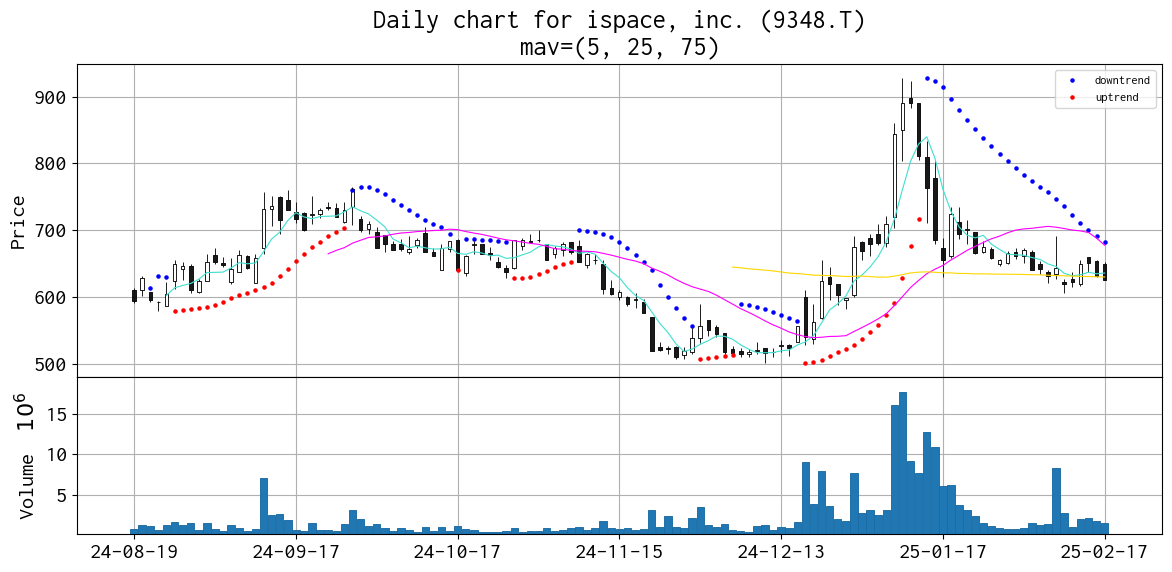

In [14]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [15]:
df.tail(2)['Close']

Date
2025-02-14 00:00:00+09:00    631.0
2025-02-17 00:00:00+09:00    626.0
Name: Close, dtype: float64

In [16]:
df.tail(2)['Close'].diff()

Date
2025-02-14 00:00:00+09:00    NaN
2025-02-17 00:00:00+09:00   -5.0
Name: Close, dtype: float64

In [17]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-02-14 00:00:00+09:00    634.8
2025-02-17 00:00:00+09:00    636.0
Name: Close, dtype: float64

In [18]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-02-14 00:00:00+09:00    688.20
2025-02-17 00:00:00+09:00    677.64
Name: Close, dtype: float64

In [19]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-02-14 00:00:00+09:00    630.333333
2025-02-17 00:00:00+09:00    630.080000
Name: Close, dtype: float64